In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diabetic-retinopathy-detection/train.zip.003
/kaggle/input/diabetic-retinopathy-detection/test.zip.004
/kaggle/input/diabetic-retinopathy-detection/test.zip.005
/kaggle/input/diabetic-retinopathy-detection/train.zip.002
/kaggle/input/diabetic-retinopathy-detection/test.zip.006
/kaggle/input/diabetic-retinopathy-detection/test.zip.003
/kaggle/input/diabetic-retinopathy-detection/train.zip.005
/kaggle/input/diabetic-retinopathy-detection/train.zip.001
/kaggle/input/diabetic-retinopathy-detection/sampleSubmission.csv.zip
/kaggle/input/diabetic-retinopathy-detection/test.zip.007
/kaggle/input/diabetic-retinopathy-detection/trainLabels.csv.zip
/kaggle/input/diabetic-retinopathy-detection/test.zip.001
/kaggle/input/diabetic-retinopathy-detection/sample.zip
/kaggle/input/diabetic-retinopathy-detection/train.zip.004
/kaggle/input/diabetic-retinopathy-detection/test.zip.002


In [11]:
# Import necessary libraries
import os
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, concatenate, Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications import ResNet50, EfficientNetB0, DenseNet121
from keras.layers import Attention
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.model_selection import StratifiedKFold
from keras import backend as K
from sklearn.metrics import accuracy_score, classification_report
#from sklearn.calibration import temperature_scaling
import shap

In [4]:
!unzip ../input/diabetic-retinopathy-detection/trainLabels.csv.zip

Archive:  ../input/diabetic-retinopathy-detection/trainLabels.csv.zip
  inflating: trainLabels.csv         


In [5]:
trainLabels = pd.read_csv("./trainLabels.csv")

In [6]:
!apt install p7zip-full -y
!7z x ../input/diabetic-retinopathy-detection/train.zip.001 "-i!train/11*.jpeg" -y # restrict extracted file to about 100 for the disk restriction
!mkdir data
!mv train data/train_11

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-7build1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan ../input/diabetic-retinopathy-detectio                                                1 file, 8388608000 bytes (8000 MiB)

Extracting archive: ../input/diabetic-retinopathy-detection/train.zip.001
  0% 1 Ope          --
Path = ../input/diabetic-retinopathy-detection/train.zip.001
Type = Split
Physical Size = 8388608000
Volumes = 5
Total Physical Size = 34988445506
----
Path = train.zip
Size = 34988445506
--
Path = train.zip
Type = zip
Physical Size = 34988445506
64-bit = +

      0% 6 - train/11008_left.jp                             

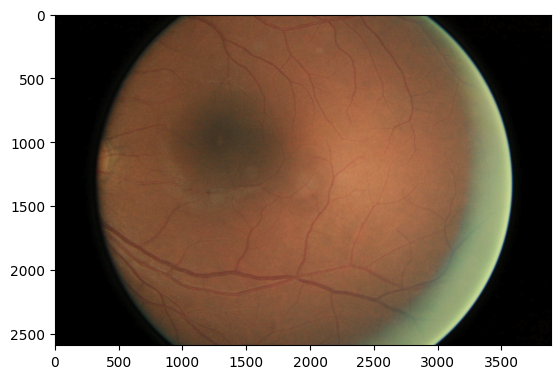

In [6]:
from PIL import Image

img = Image.open("./data/train_11/1116_right.jpeg")

import matplotlib.pyplot as plt

plt.imshow(img)

In [7]:
!7z x ../input/diabetic-retinopathy-detection/test.zip.001 "-i!test/11*.jpeg" -y # restrict extracted file to about 100 for the disk restriction

!mv test data/test_11


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan ../input/diabetic-retinopathy-detectio                                                1 file, 8388608000 bytes (8000 MiB)

Extracting archive: ../input/diabetic-retinopathy-detection/test.zip.001
  0% 1 Ope          --
Path = ../input/diabetic-retinopathy-detection/test.zip.001
Type = Split
Physical Size = 8388608000
Volumes = 7
Total Physical Size = 53289598430
----
Path = test.zip
Size = 53289598430
--
Path = test.zip
Type = zip
Physical Size = 53289598430
64-bit = +

      0% 7 - test/11004_right.jp                              1% 15 - test/11012_right.jpe                                1% 24 - test/11018_left.jp                              2% 32 - test/11021_left.jp                              2% 41 - test/11027_right.jpe                          

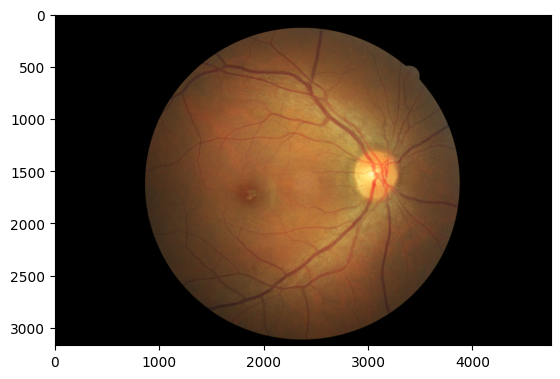

In [13]:
img = Image.open("./data/test_11/11193_right.jpeg")

plt.imshow(img)

In [8]:
!cp ../input/diabetic-retinopathy-detection/trainLabels.csv.zip data

In [9]:
!ls data

test_11  trainLabels.csv.zip  train_11


In [10]:
base_image_dir = os.path.join('.', 'data/train_11')
df = pd.read_csv(os.path.join('trainLabels.csv'))
df.head(10)

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
5,15_right,2
6,16_left,4
7,16_right,4
8,17_left,0
9,17_right,1


In [11]:
import os
import cv2
import numpy as np
import imgaug.augmenters as iaa

def apply_adaptive_histogram_equalization(image_path, output_folder):
    # Read the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply Adaptive Histogram Equalization
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized_img = clahe.apply(img)

    # Save the result
    filename = os.path.basename(image_path)
    output_path = os.path.join(output_folder, filename)
    cv2.imwrite(output_path, equalized_img)

def apply_advanced_augmentations(image_path, output_folder):
    # Read the image
    img = cv2.imread(image_path)

    # Define augmentations
    seq = iaa.Sequential([
        iaa.ElasticTransformation(alpha=50, sigma=5),
        iaa.AdditiveGaussianNoise(scale=0.05 * 255)
    ])

    # Apply augmentations
    augmented_img = seq.augment_image(img)

    # Save the result
    filename = os.path.basename(image_path)
    output_path = os.path.join(output_folder, filename)
    cv2.imwrite(output_path, augmented_img)

def apply_gaussian_blurring(image_path, output_folder):
    # Read the image
    img = cv2.imread(image_path)

    # Apply Gaussian Blurring
    blurred_img = cv2.GaussianBlur(img, (5, 5), 0)

    # Save the result
    filename = os.path.basename(image_path)
    output_path = os.path.join(output_folder, filename)
    cv2.imwrite(output_path, blurred_img)
    
def process_images_in_folder(input_folder, output_folder, processing_function):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Process each image in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".jpeg"):
            input_path = os.path.join(input_folder, filename)
            processing_function(input_path, output_folder)
            print(f"Processed: {filename}")

if __name__ == "__main__":
    # Set paths
    input_folder = "data/train_11"  # Replace with the actual path to your input folder
    output_folder_equalization = "data/train_11_eq"
    output_folder_augmentation = "data/train_11_aug"
    output_folder_blurring = "data/train_11_blur"

    # Apply Adaptive Histogram Equalization
    process_images_in_folder(input_folder, output_folder_equalization, apply_adaptive_histogram_equalization)

    # Apply Image Augmentation
    process_images_in_folder(input_folder, output_folder_augmentation, apply_advanced_augmentations)

    # Apply Gaussian Blurring
    process_images_in_folder(input_folder, output_folder_blurring, apply_gaussian_blurring)

Processed: 11726_left.jpeg
Processed: 11314_right.jpeg
Processed: 11431_left.jpeg
Processed: 11870_left.jpeg
Processed: 11301_left.jpeg
Processed: 11083_left.jpeg
Processed: 11387_left.jpeg
Processed: 11740_left.jpeg
Processed: 11187_left.jpeg
Processed: 11730_left.jpeg
Processed: 1179_right.jpeg
Processed: 1162_left.jpeg
Processed: 1100_right.jpeg
Processed: 11677_right.jpeg
Processed: 11631_right.jpeg
Processed: 11768_right.jpeg
Processed: 11550_left.jpeg
Processed: 11736_right.jpeg
Processed: 11824_left.jpeg
Processed: 11720_left.jpeg
Processed: 11283_right.jpeg
Processed: 11395_right.jpeg
Processed: 11153_right.jpeg
Processed: 11966_left.jpeg
Processed: 1138_left.jpeg
Processed: 11727_right.jpeg
Processed: 1161_right.jpeg
Processed: 11734_left.jpeg
Processed: 11448_left.jpeg
Processed: 11529_right.jpeg
Processed: 11387_right.jpeg
Processed: 11727_left.jpeg
Processed: 11937_right.jpeg
Processed: 11909_left.jpeg
Processed: 11856_right.jpeg
Processed: 11575_right.jpeg
Processed: 11773

In [12]:
from PIL import Image
import matplotlib.pyplot as plt

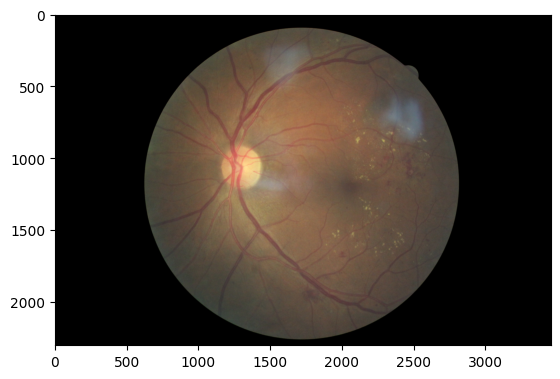

In [13]:
original_img = Image.open("./data/train_11/11871_left.jpeg")
plt.imshow(original_img)

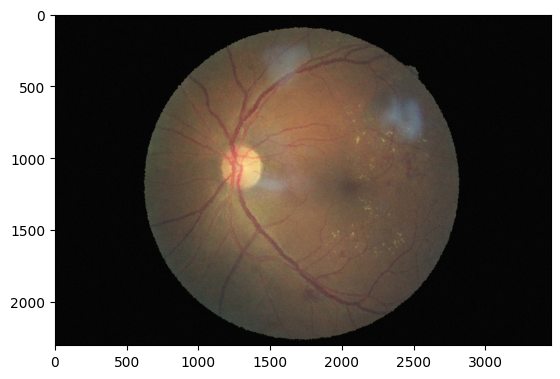

In [14]:
augmented_img = Image.open("./data/train_11_aug/11871_left.jpeg")
plt.imshow(augmented_img)

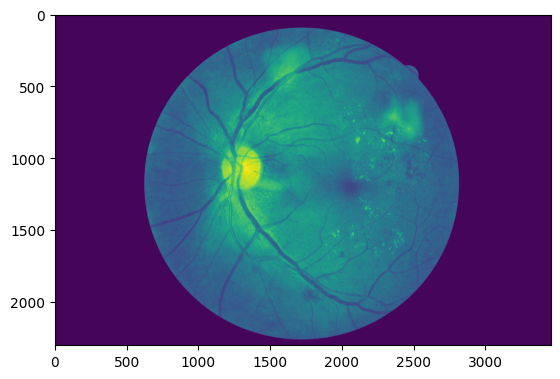

In [15]:
equalized_img = Image.open("./data/train_11_eq/11871_left.jpeg")
plt.imshow(equalized_img)

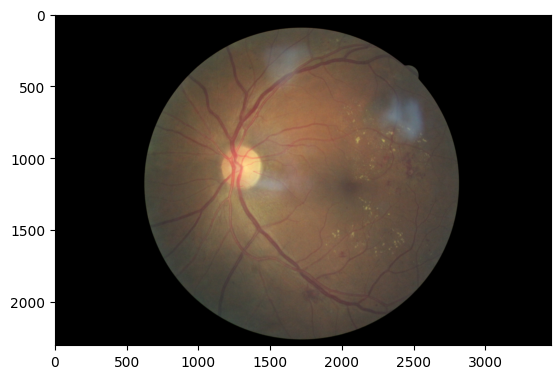

In [16]:
blur_img = Image.open("./data/train_11_blur/11871_left.jpeg")
plt.imshow(blur_img)

In [41]:
!ls data

test_11  trainLabels.csv  trainLabels.csv.zip  train_11  train_11_eq


In [32]:
base_image_dir = os.path.join('.', 'data/train_11')
df = pd.read_csv(os.path.join('data/trainLabels.csv'))
df['path'] = df['image'].map(lambda x: os.path.join(base_image_dir,'{}.jpeg'.format(x)))
df['exists'] = df['path'].map(os.path.exists) #Most of the files do not exist because this is a sample of the original dataset
df = df[df['exists']]
df = df.drop(columns=['image','exists'])
df = df.sample(frac=1).reset_index(drop=True)#shuffle dataframe
df['level'] = df['level'].astype(str)
df.head(10)


,level,path
0,0,./data/train_11/11232_left.jpeg
1,0,./data/train_11/11375_right.jpeg
2,0,./data/train_11/11378_right.jpeg
3,2,./data/train_11/1152_right.jpeg
4,0,./data/train_11/11598_left.jpeg
5,0,./data/train_11/11005_right.jpeg
6,0,./data/train_11/11679_left.jpeg
7,0,./data/train_11/11593_right.jpeg
8,0,./data/train_11/11551_right.jpeg
9,2,./data/train_11/11703_left.jpeg


In [27]:
# Function to load and preprocess images
def load_and_preprocess_images(image_paths, target_size=(224, 224), augment=False):
    img_list = []
    for path in image_paths:
        img = image.load_img(path, target_size=target_size)
        img = image.img_to_array(img)
        img /= 255.0  # Normalize pixel values to be between 0 and 1
        img_list.append(img)

    return np.array(img_list)

In [35]:
# Function to create an ensemble model
def create_ensemble_model(input_shape, num_classes):
    # Define base models
    base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model_efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers of base models
    for layer in base_model_resnet.layers:
        layer.trainable = False
    for layer in base_model_efficientnet.layers:
        layer.trainable = False
    for layer in base_model_densenet.layers:
        layer.trainable = False

    # Create input layer
    input_tensor = Input(shape=input_shape)

    # Get intermediate layer outputs
    resnet_features = base_model_resnet(input_tensor)
    efficientnet_features = base_model_efficientnet(input_tensor)
    densenet_features = base_model_densenet(input_tensor)

    # Concatenate features
    concatenated_features = concatenate([resnet_features, efficientnet_features, densenet_features], axis=-1)

    # Global average pooling layer
    x = GlobalAveragePooling2D()(concatenated_features)

    # Dropout layer
    x = Dropout(0.5)(x)

    # Output layer
    output = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=input_tensor, outputs=output)

    # Compile model
    model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Function to train the model
def train_model(model, train_data, train_labels, val_data, val_labels, epochs=30, batch_size=32):
    # Define callbacks
    checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

    # Train the model
    history = model.fit(
        train_data,
        train_labels,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(val_data, val_labels),
        callbacks=[checkpoint, early_stopping]
    )

    return history

# Function to evaluate the model
def evaluate_model(model, test_data, test_labels):
    predictions = model.predict(test_data)
    y_pred = np.argmax(predictions, axis=1)
    y_true = np.argmax(test_labels, axis=1)

    accuracy = accuracy_score(y_true, y_pred)
    print("Test Accuracy:", accuracy)

    report = classification_report(y_true, y_pred)
    print("Classification Report:\n", report)

# Function for model calibration using temperature scaling
def calibrate_model(model, val_data, val_labels):
    val_predictions = model.predict(val_data)
    temperature = temperature_scaling(val_labels, val_predictions)
    calibrated_predictions = val_predictions / temperature

    return calibrated_predictions

# Function to visualize feature importance using SHAP
def visualize_feature_importance(model, data, background_data):
    # Create a SHAP explainer
    explainer = shap.Explainer(model, background_data)

    # Calculate SHAP values
    shap_values = explainer.shap_values(data)

    # Plot feature importance
    shap.summary_plot(shap_values, data)

# Main script
if __name__ == "__main__":
    # Set paths
    data_folder = "data"

    # Extract images from train zip files
    train_images_folder = "train_11"
    
    # Extract images from test zip files
    test_images_folder = "test_11"
    
    # Load labels
    labels_df = df
    image_paths = [os.path.join(train_images_folder, f"{idx}_left.jpeg") for idx in labels_df['image']]
    image_paths += [os.path.join(train_images_folder, f"{idx}_right.jpeg") for idx in labels_df['image']]
    labels = labels_df['level'].values

    # Split the data into training and validation sets
    train_data, val_data, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42, stratify=labels)

    # Load and preprocess training and validation data
    train_images = load_and_preprocess_images(train_data, augment=True)
    val_images = load_and_preprocess_images(val_data)

    # Convert labels to one-hot encoding
    le = LabelEncoder()
    train_labels_encoded = to_categorical(le.fit_transform(train_labels))
    val_labels_encoded = to_categorical(le.transform(val_labels))

    # Data augmentation
    datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
    )
    datagen.fit(train_images)

    # Train-test split for calibration
    calib_train_data, calib_val_data, calib_train_labels, calib_val_labels = train_test_split(train_images, train_labels_encoded, test_size=0.1, random_state=42, stratify=train_labels_encoded)

    # Create an ensemble model
    input_shape = (224, 224, 3)  # Adjust based on the target model input size
    num_classes = 5  # 0 to 4 severity levels
    ensemble_model = create_ensemble_model(input_shape, num_classes)

    # Train the model
    history = train_model(ensemble_model, datagen.flow(train_images, train_labels_encoded, batch_size=32), epochs=30, batch_size=32)

    # Evaluate the model
    evaluate_model(ensemble_model, val_images, val_labels_encoded)

    # Calibrate the model
    calibrated_predictions = calibrate_model(ensemble_model, calib_val_data, calib_val_labels)

    # Visualize feature importance using SHAP
    background_data = calib_train_data[np.random.choice(calib_train_data.shape[0], 100, replace=False)]
    visualize_feature_importance(ensemble_model, calib_val_data, background_data)

ValueError: Found input variables with inconsistent numbers of samples: [70252, 35126]

In [ ]:
if __name__ == "__main__":
    # Set paths
    data_folder = "data"

    # Extract images from train zip files
    train_images_folder = "train_11"
    

    # Extract images from test zip files
    test_images_folder = "test_11"
    
    # Load labels
    labels_df = pd.read_csv(os.path.join(data_folder, labels_file))
    image_paths = [os.path.join(train_images_folder, f"{idx}_left.jpeg") for idx in labels_df['image']]
    image_paths += [os.path.join(train_images_folder, f"{idx}_right.jpeg") for idx in labels_df['image']]
    labels = labels_df['level'].values

    # Split the data into training and validation sets
    train_data, val_data, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42, stratify=labels)

    # Load and preprocess training and validation data
    train_images = load_and_preprocess_images(train_data, augment=True)
    val_images = load_and_preprocess_images(val_data)

    # Convert labels to one-hot encoding
    le = LabelEncoder()
    train_labels_encoded = to_categorical(le.fit_transform(train_labels))
    val_labels_encoded = to_categorical(le.transform(val_labels))

    # Data augmentation
    datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
    )
    datagen.fit(train_images)

    # Train-test split for calibration
    calib_train_data, calib_val_data, calib_train_labels, calib_val_labels = train_test_split(train_images, train_labels_encoded, test_size=0.1, random_state=42, stratify=train_labels_encoded)
